In [2]:
import random

import os
import sys

os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps'
os.environ['MOMAPS_DATA_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps/input'

sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")
from sklearn.metrics import silhouette_score, davies_bouldin_score
from src.common.lib.embeddings_distances_utils_vit import calc_embeddings_distances_for_vit, plot_distances_plot, create_markers_centroids_df
from src.common.lib.utils import load_config_file, get_if_exists, init_logging
from src.runables.calculate_embeddings_distances_vit import __load_vit_features
from matplotlib.patches import Rectangle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

from scipy.stats import ranksums, ttest_ind, mannwhitneyu
import seaborn as sns

%matplotlib inline


%load_ext autoreload
%autoreload 2

np.random.seed(1)

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### opencell

In [3]:
distances_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/opencell_new/figures/neurons/distances/between_cell_lines_conds_distances.csv"

### Freeze least changed layers

In [2]:
distances_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/transfer_b78_freeze_least_changed/figures/neurons/distances/between_cell_lines_conds_distances.csv"

## Main

In [3]:
distances_full = pd.read_csv(distances_path)
distances_full

,dist,marker,batch_1,rep_1,batch_2,rep_2,cell_line_condition_1,cell_line_condition_2
0,0.000000,ANXA11,batch6,rep1,batch6,rep1,FUSHeterozygous_Untreated,FUSHeterozygous_Untreated
1,10.576057,ANXA11,batch6,rep1,batch6,rep2,FUSHeterozygous_Untreated,FUSHeterozygous_Untreated
2,9.569879,ANXA11,batch6,rep1,batch7,rep1,FUSHeterozygous_Untreated,FUSHeterozygous_Untreated
3,13.385067,ANXA11,batch6,rep1,batch7,rep2,FUSHeterozygous_Untreated,FUSHeterozygous_Untreated
4,18.511589,ANXA11,batch6,rep1,batch8,rep1,FUSHeterozygous_Untreated,FUSHeterozygous_Untreated
...,...,...,...,...,...,...,...,...
62568,8.635003,mitotracker,batch8,rep2,batch9,rep1,WT_stress,WT_stress
62569,9.390301,mitotracker,batch8,rep2,batch9,rep2,WT_stress,WT_stress
62570,0.000000,mitotracker,batch9,rep1,batch9,rep1,WT_stress,WT_stress
62571,5.851143,mitotracker,batch9,rep1,batch9,rep2,WT_stress,WT_stress


In [31]:
distances_full[(distances_full['batch_1'] == 'batch6') & (distances_full['batch_2'] == 'batch6') & (distances_full['marker'] == 'ANXA11') & (distances_full['cell_line_condition_1'] == 'WT_Untreated') & (distances_full['cell_line_condition_2'] == 'WT_Untreated')]

,dist,marker,batch_1,rep_1,batch_2,rep_2,cell_line_condition_1,cell_line_condition_2
2492,0.000000,ANXA11,batch6,rep1,batch6,rep1,WT_Untreated,WT_Untreated
2493,1.724342,ANXA11,batch6,rep1,batch6,rep2,WT_Untreated,WT_Untreated
2508,0.000000,ANXA11,batch6,rep2,batch6,rep2,WT_Untreated,WT_Untreated


In [32]:
distances_full[(distances_full['batch_1'] == 'batch6') & (distances_full['batch_2'] == 'batch6') & (distances_full['marker'] == 'ANXA11') & (distances_full['cell_line_condition_1'] == 'WT_Untreated') & (distances_full['cell_line_condition_2'] == 'WT_stress')]

,dist,marker,batch_1,rep_1,batch_2,rep_2,cell_line_condition_1,cell_line_condition_2
2500,6.764099,ANXA11,batch6,rep1,batch6,rep1,WT_Untreated,WT_stress
2501,5.493304,ANXA11,batch6,rep1,batch6,rep2,WT_Untreated,WT_stress
2515,6.390994,ANXA11,batch6,rep2,batch6,rep1,WT_Untreated,WT_stress
2516,4.947050,ANXA11,batch6,rep2,batch6,rep2,WT_Untreated,WT_stress


In [33]:
distances_full[(distances_full['batch_1'] == 'batch6') & (distances_full['batch_2'] == 'batch6') & (distances_full['marker'] == 'DAPI') & (distances_full['cell_line_condition_1'] == 'WT_Untreated') & (distances_full['cell_line_condition_2'] == 'WT_stress')]

,dist,marker,batch_1,rep_1,batch_2,rep_2,cell_line_condition_1,cell_line_condition_2
13012,0.998420,DAPI,batch6,rep1,batch6,rep1,WT_Untreated,WT_stress
13013,1.063190,DAPI,batch6,rep1,batch6,rep2,WT_Untreated,WT_stress
13027,1.203946,DAPI,batch6,rep2,batch6,rep1,WT_Untreated,WT_stress
13028,1.081661,DAPI,batch6,rep2,batch6,rep2,WT_Untreated,WT_stress


In [48]:
## filter for single rep

batch = 'batch6'
rep = 'rep2'

# distances = distances_full[(distances_full['batch_1'] == batch) & (distances_full['batch_2'] == batch)]# & (distances_full['rep_1']==rep) & (distances_full['rep_2']==rep)]
distances = distances_full.copy()
distances = distances[(distances['cell_line_condition_1'] == 'WT_Untreated') & (distances['cell_line_condition_2'] == 'WT_stress')]
# distances = distances[(distances['batch_1'].isin(['batch6','batch9'])) & (distances['batch_2'].isin(['batch6','batch9']))]

## Get the median of all batches&reps per marker and cell_line&condiiton
# distances = distances.groupby(['marker', 'cell_line_condition_1', 'cell_line_condition_2'])[['dist']].median()
distances = distances.set_index(['marker', 'cell_line_condition_1', 'cell_line_condition_2', 'batch_1', 'batch_2'])
indexes = distances.index

# distances.iloc[:50]
# distances.loc[pd.IndexSlice['ANXA11', 'FUSHeterozygous_Untreated', 'FUSHeterozygous_Untreated'], 'dist'].values
# # Statistical testing

from scipy.spatial.distance import jensenshannon

cell_lines_compared = []

for marker, cell_line_condition_1, cell_line_condition_2, batch_1, batch_2 in indexes: 
    if cell_line_condition_1 == cell_line_condition_2:
        continue
    idx = {marker, cell_line_condition_1, cell_line_condition_2, batch_1, batch_2} # set
    if idx in cell_lines_compared:
        continue
    if batch_1 != batch_2:
        continue
    if marker == 'DAPI':
        continue
        
    current_dist = distances.loc[pd.IndexSlice[marker, cell_line_condition_1, cell_line_condition_2, batch_1, batch_2], 'dist'].values
    current_DAPI_dist = distances.loc[pd.IndexSlice['DAPI', cell_line_condition_1, cell_line_condition_2, batch_1, batch_2], 'dist'].values
    
    cell_lines_compared.append(idx)
    
    # wilcoxon
    stat, p_value = ranksums(current_dist, current_DAPI_dist, alternative='greater')
    # stat, p_value = ttest_ind(current_dist, current_DAPI_dist, alternative='greater')
    # p_value = 0
    # stat = jensenshannon(current_dist, current_DAPI_dist)
    
    print(f"{marker}, {cell_line_condition_1}, {cell_line_condition_2}, {batch_1}, {batch_2}: {current_dist} (DAPI: {current_DAPI_dist}) || p={p_value} ({stat})")
    print()
    



ANXA11, WT_Untreated, WT_stress, batch6, batch6: [6.76409866 5.49330403 6.3909944  4.94705034] (DAPI: [0.99841991 1.06319039 1.20394623 1.0816611 ]) || p=0.010460667668897007 (2.3094010767585034)

ANXA11, WT_Untreated, WT_stress, batch7, batch7: [12.37169188 15.13326755 10.50592657 12.88284498] (DAPI: [1.84864343 1.81989953 1.15543209 1.9967399 ]) || p=0.010460667668897007 (2.3094010767585034)

ANXA11, WT_Untreated, WT_stress, batch8, batch8: [ 8.91498964  8.60700954 10.34301185  8.29373994] (DAPI: [0.731819   1.02043499 0.96179272 1.2204264 ]) || p=0.010460667668897007 (2.3094010767585034)

ANXA11, WT_Untreated, WT_stress, batch9, batch9: [ 7.2877451   6.40362182 10.1309514   9.07384755] (DAPI: [1.26674146 0.94677511 1.53509302 1.14680233]) || p=0.010460667668897007 (2.3094010767585034)

CD41, WT_Untreated, WT_stress, batch6, batch6: [13.63749591  8.56437379 11.50536192  5.22881879] (DAPI: [0.99841991 1.06319039 1.20394623 1.0816611 ]) || p=0.010460667668897007 (2.3094010767585034)

C

/tmp/ipykernel_1571263/3691561219.py:35: PerformanceWarning: indexing past lexsort depth may impact performance.
  current_dist = distances.loc[pd.IndexSlice[marker, cell_line_condition_1, cell_line_condition_2, batch_1, batch_2], 'dist'].values
/tmp/ipykernel_1571263/3691561219.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  current_DAPI_dist = distances.loc[pd.IndexSlice['DAPI', cell_line_condition_1, cell_line_condition_2, batch_1, batch_2], 'dist'].values


## Testing with silhouette score

### Calc scores

In [6]:
model_output_folder = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/transfer_b78_freeze_least_changed"
config_path_data = "./src/distances/model_comparisons_distances_config/NeuronsDistanceConfig"

config_data = load_config_file(config_path_data, 'data')
config_data.INPUT_FOLDERS = ['/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch6', 
                            '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9']
config_data.REPS = []#['rep2']
output_folder_path = os.path.join(model_output_folder, 'figures', config_data.EXPERIMENT_TYPE, 'distances')
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path, exist_ok=True)

train_batches = get_if_exists(config_data, 'TRAIN_BATCHES', None)
assert train_batches is not None, "train_batches can't be None for distances" 

embeddings, labels = __load_vit_features(model_output_folder, config_data, train_batches)



In [7]:
labels

array(['TOMM20_WT_Untreated_batch6_rep2',
       'ANXA11_TBK1_Untreated_batch6_rep1',
       'DAPI_WT_Untreated_batch6_rep2', ...,
       'DAPI_WT_Untreated_batch9_rep2', 'FUS_SCNA_Untreated_batch9_rep2',
       'Calreticulin_WT_Untreated_batch9_rep2'], dtype=object)

In [50]:

# ALS_lines = ['FUSHomozygous','FUSHeterozygous','FUSRevertant', 'OPTN','SCNA','TBK1','TDP43']
# conditions = [als+'_Untreated' for als in ALS_lines] + ['WT_stress']
conditions = ['TBK1_Untreated']#, 'TBK1_Untreated']#['WT_stress']
markers = np.unique([label.split('_')[0] for label in np.unique(labels)])
batches = ['batch6', 'batch9']

scores = pd.DataFrame(columns=['silhouette','dunn','marker', 'condition', 'repA', 'repB', 'batch'])
for batch in batches:
    print(f"batch: {batch}")
    for marker in markers:   
        
        ## SKIP DAPI for sake of time
        if marker == 'DAPI':
            print("Skipping DAPI..")
            continue
        
        print(f"marker: {marker}")
        
        print(f"cell line: WT Untreated")
        marker_wt_idx_r1 = np.where(np.char.find(labels.astype(str), f'{marker}_WT_Untreated_{batch}_rep1')>-1)[0]
        marker_wt_idx_r2 = np.where(np.char.find(labels.astype(str), f'{marker}_WT_Untreated_{batch}_rep2')>-1)[0]

        r1_size1 = len(marker_wt_idx_r1) // 2
        r2_size1 = len(marker_wt_idx_r2) // 2

        r1_part1 = np.random.choice(np.arange(len(marker_wt_idx_r1)), r1_size1, replace=False)
        r1_part2 = np.delete(marker_wt_idx_r1, r1_part1)

        r2_part1 = np.random.choice(np.arange(len(marker_wt_idx_r2)), r2_size1, replace=False)
        r2_part2 = np.delete(marker_wt_idx_r2, r2_part1)

        d = {'rep1_part1': r1_part1, 'rep1_part2': r1_part2, 'rep2_part1': r2_part1, 'rep2_part2': r2_part2}
        partial_reps = itertools.product(['rep1_part1', 'rep1_part2'], ['rep2_part1', 'rep2_part2'])

        for ra,rb in partial_reps:
            d_ra, d_rb = d[ra], d[rb]
            cur_labels = np.concatenate([[ra]*len(d_ra),[rb]*len(d_rb)])
            cur_embeddings = np.concatenate([embeddings[d_ra],embeddings[d_rb]])
            score = pd.DataFrame({'silhouette':[silhouette_score(cur_embeddings, cur_labels)],
                                      'marker':[marker],
                                     'condition': ['WT_Untreated'],
                                     'repA':[ra],
                                     'repB': [rb],
                                     'batch': [batch]})
            if scores.shape[0]==0:
                scores = score
            else:
                scores = pd.concat([scores, score])
    
        
        
        for als in conditions:
            print(f"cell line: {als}")
            reps = itertools.product(['rep1', 'rep2'], repeat=2)
            for repA,repB in reps:
                marker_als_idx = np.where(np.char.find(labels.astype(str), f'{marker}_{als}_{batch}_{repA}')>-1)[0]
                marker_wt_idx = np.where(np.char.find(labels.astype(str), f'{marker}_WT_Untreated_{batch}_{repB}')>-1)[0]
                cur_labels = np.concatenate([labels[marker_wt_idx],labels[marker_als_idx]])
                cur_embeddings = np.concatenate([embeddings[marker_wt_idx],embeddings[marker_als_idx]])
                score = pd.DataFrame({'silhouette':[silhouette_score(cur_embeddings, cur_labels)],
                                      # 'dunn':[davies_bouldin_score(cur_embeddings, cur_labels)],
                                      'dunn': [None],
                                      'marker':[marker],
                                     'condition': [als],
                                     'repA':[repA],
                                     'repB': [repB],
                                     'batch': [batch]})
                if scores.shape[0]==0:
                    scores = score
                else:
                    scores = pd.concat([scores, score])
    # fig, axs = plt.subplots(ncols=2, figsize=(10,3))
    # scores.sort_values(by='silhouette',ascending=False).plot(kind='bar',x='marker',y='silhouette',
    #                                                         ax=axs[0])
    # scores.sort_values(by='dunn',ascending=True).plot(kind='bar',x='marker',y='dunn',
    #                                                     ax=axs[1])
    # fig.suptitle(f'{als} vs WT Untreated')
    # plt.show()

# for batch in batches:
#     for marker in markers:
#         marker_wt_idx_r1 = np.where(np.char.find(labels.astype(str), f'{marker}_WT_Untreated_{batch}_rep1')>-1)[0]
#         marker_wt_idx_r2 = np.where(np.char.find(labels.astype(str), f'{marker}_WT_Untreated_{batch}_rep2')>-1)[0]

#         r1_size1 = len(marker_wt_idx_r1) // 2
#         r2_size1 = len(marker_wt_idx_r2) // 2

#         r1_part1 = np.random.choice(np.arange(len(marker_wt_idx_r1)), r1_size1, replace=False)
#         r1_part2 = np.delete(marker_wt_idx_r1, r1_part1)

#         r2_part1 = np.random.choice(np.arange(len(marker_wt_idx_r2)), r2_size1, replace=False)
#         r2_part2 = np.delete(marker_wt_idx_r2, r2_part1)

#         d = {'rep1_part1': r1_part1, 'rep1_part2': r1_part2, 'rep2_part1': r2_part1, 'rep2_part2': r2_part2}
#         partial_reps = itertools.product(['rep1_part1', 'rep1_part2'], ['rep2_part1', 'rep2_part2'])

#         for ra,rb in partial_reps:
#             d_ra, d_rb = d[ra], d[rb]
#             cur_labels = np.concatenate([[ra]*len(d_ra),[rb]*len(d_rb)])
#             cur_embeddings = np.concatenate([embeddings[d_ra],embeddings[d_rb]])
#             score = pd.DataFrame({'silhouette':[silhouette_score(cur_embeddings, cur_labels)],
#                                       'marker':[marker],
#                                      'condition': ['WT_Untreated'],
#                                      'repA':[ra],
#                                      'repB': [rb],
#                                      'batch': [batch]})
#             scores = pd.concat([scores, score])
    
scores

batch: batch6
marker: ANXA11
cell line: WT Untreated
cell line: TBK1_Untreated
marker: CD41
cell line: WT Untreated
cell line: TBK1_Untreated
marker: CLTC
cell line: WT Untreated
cell line: TBK1_Untreated
marker: Calreticulin
cell line: WT Untreated
cell line: TBK1_Untreated
Skipping DAPI..
marker: DCP1A
cell line: WT Untreated
cell line: TBK1_Untreated
marker: FUS
cell line: WT Untreated
cell line: TBK1_Untreated
marker: G3BP1
cell line: WT Untreated
cell line: TBK1_Untreated
marker: GM130
cell line: WT Untreated
cell line: TBK1_Untreated
marker: KIF5A
cell line: WT Untreated
cell line: TBK1_Untreated
marker: LAMP1
cell line: WT Untreated
cell line: TBK1_Untreated
marker: NCL
cell line: WT Untreated
cell line: TBK1_Untreated
marker: NEMO
cell line: WT Untreated
cell line: TBK1_Untreated
marker: NONO
cell line: WT Untreated
cell line: TBK1_Untreated
marker: PEX14
cell line: WT Untreated
cell line: TBK1_Untreated
marker: PML
cell line: WT Untreated
cell line: TBK1_Untreated
marker: PSD9

,silhouette,marker,condition,repA,repB,batch,dunn
0,-0.001144,ANXA11,WT_Untreated,rep1_part1,rep2_part1,batch6,NaN
0,0.208669,ANXA11,WT_Untreated,rep1_part1,rep2_part2,batch6,NaN
0,0.236822,ANXA11,WT_Untreated,rep1_part2,rep2_part1,batch6,NaN
0,0.005982,ANXA11,WT_Untreated,rep1_part2,rep2_part2,batch6,NaN
0,0.544856,ANXA11,TBK1_Untreated,rep1,rep1,batch6,NaN
...,...,...,...,...,...,...,...
0,0.012803,mitotracker,WT_Untreated,rep1_part2,rep2_part2,batch9,NaN
0,0.117467,mitotracker,TBK1_Untreated,rep1,rep1,batch9,NaN
0,0.103284,mitotracker,TBK1_Untreated,rep1,rep2,batch9,NaN
0,0.105206,mitotracker,TBK1_Untreated,rep2,rep1,batch9,NaN


### Load scores

In [3]:
# scores_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/transfer_b78_freeze_least_changed/figures/neurons/distances/silhouette_score_batch6_batch9_full_batch7_batch8_testset.csv"
# scores_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/transfer_b78_freeze_least_changed/figures/neurons/distances/silhouette_score_batch6_batch9.csv"

# dNLS
scores_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/transfer_b78_freeze_least_changed/figures/deltaNLS/distances/silhouette_score_batch3_batch4_batch5_TDP43_Untreated.csv"

# scores_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/opencell_new/figures/neurons/distances/silhouette_score_batch6_batch9_full_batch7_batch8_testset.csv"
scores = pd.read_csv(scores_path)
# scores.drop(columns={"Unnamed: 0"}, inplace=True)
scores

,silhouette,marker,condition,repA,repB,batch
0,-0.001914,ANXA11,TDP43_Untreated,rep1_part1,rep2_part1,batch3
1,0.159643,ANXA11,TDP43_Untreated,rep1_part1,rep2_part2,batch3
2,0.161053,ANXA11,TDP43_Untreated,rep1_part2,rep2_part1,batch3
3,0.000457,ANXA11,TDP43_Untreated,rep1_part2,rep2_part2,batch3
4,0.010883,ANXA11,TDP43_dox,rep1,rep1,batch3
...,...,...,...,...,...,...
1047,0.035088,mitotracker,TDP43_dox,rep2,rep2,batch5
1048,0.065457,mitotracker,WT_Untreated,rep1,rep1,batch5
1049,0.061455,mitotracker,WT_Untreated,rep1,rep2,batch5
1050,0.065262,mitotracker,WT_Untreated,rep2,rep1,batch5


In [4]:
def get_p(func, cond, baseline):
    return lambda x: func(x.loc[x['condition'] == cond, 'silhouette'], x.loc[x['condition'] == baseline, 'silhouette'], alternative='greater')[1]

In [5]:
baseline = 'TDP43_Untreated' # 'WT_Untreated' 
func = ttest_ind

##

conds = scores['condition'].unique()
conds = np.delete(conds,np.where(conds == baseline)[0]) # remove baseline

pvalues = None
for cond in conds:
    scores_cond = scores[scores['condition'].isin([cond, baseline])]
    pvalues_cond = scores_cond.groupby('marker').apply(get_p(func, cond, baseline)).sort_values(ascending=True).rename('pvalues').reset_index()
    cond_series = pd.Series([cond]*len(pvalues_cond), name='condition')
    pvalues_cond_df = pd.merge(cond_series, pvalues_cond, left_index=True, right_index=True)
    if pvalues is None:
        pvalues = pvalues_cond_df
    else:
        pvalues = pd.concat([pvalues,  pvalues_cond_df])
    # print(f"Condition: {cond} \n {pvalues_cond}")
    
df_merged = pd.merge(scores, pvalues, on=['marker', 'condition'])
df_merged

/tmp/ipykernel_950750/3636057453.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvalues_cond = scores_cond.groupby('marker').apply(get_p(func, cond, baseline)).sort_values(ascending=True).rename('pvalues').reset_index()
/tmp/ipykernel_950750/3636057453.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvalues_cond = scores_cond.groupby('marker').apply(get_p(func, cond, baseline)).sort_values(ascend

,silhouette,marker,condition,repA,repB,batch,pvalues
0,0.010883,ANXA11,TDP43_dox,rep1,rep1,batch3,0.989727
1,0.010807,ANXA11,TDP43_dox,rep1,rep2,batch3,0.989727
2,0.036139,ANXA11,TDP43_dox,rep2,rep1,batch3,0.989727
3,0.040653,ANXA11,TDP43_dox,rep2,rep2,batch3,0.989727
4,0.006243,ANXA11,WT_Untreated,rep1,rep1,batch3,0.991293
...,...,...,...,...,...,...,...
695,0.035088,mitotracker,TDP43_dox,rep2,rep2,batch5,0.989959
696,0.065457,mitotracker,WT_Untreated,rep1,rep1,batch5,0.886212
697,0.061455,mitotracker,WT_Untreated,rep1,rep2,batch5,0.886212
698,0.065262,mitotracker,WT_Untreated,rep2,rep1,batch5,0.886212


### Plot

#### barplot

/tmp/ipykernel_950750/1166607274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond['marker'] = pd.Categorical(df_cond['marker'], categories=sorted_markers, ordered=True)


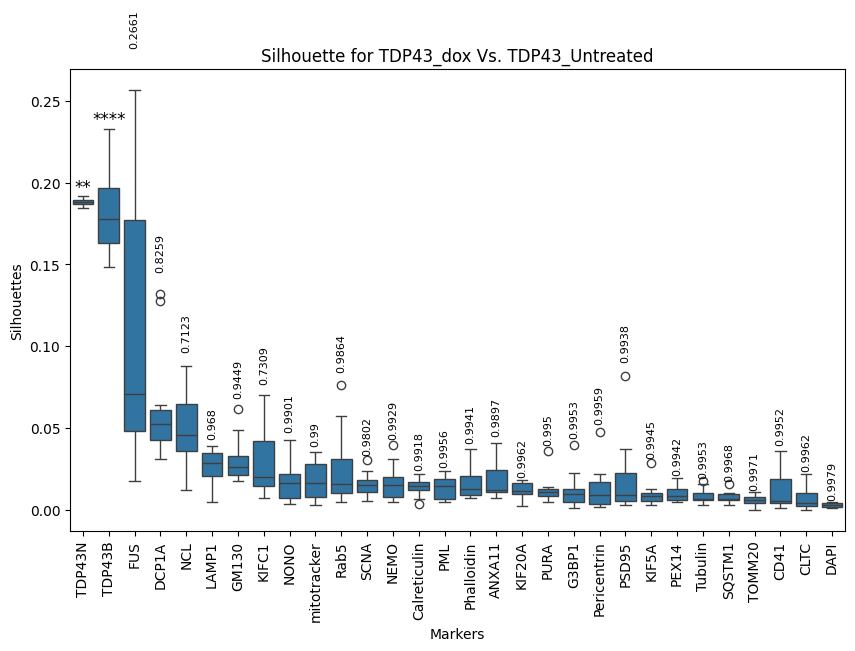

/tmp/ipykernel_950750/1166607274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond['marker'] = pd.Categorical(df_cond['marker'], categories=sorted_markers, ordered=True)


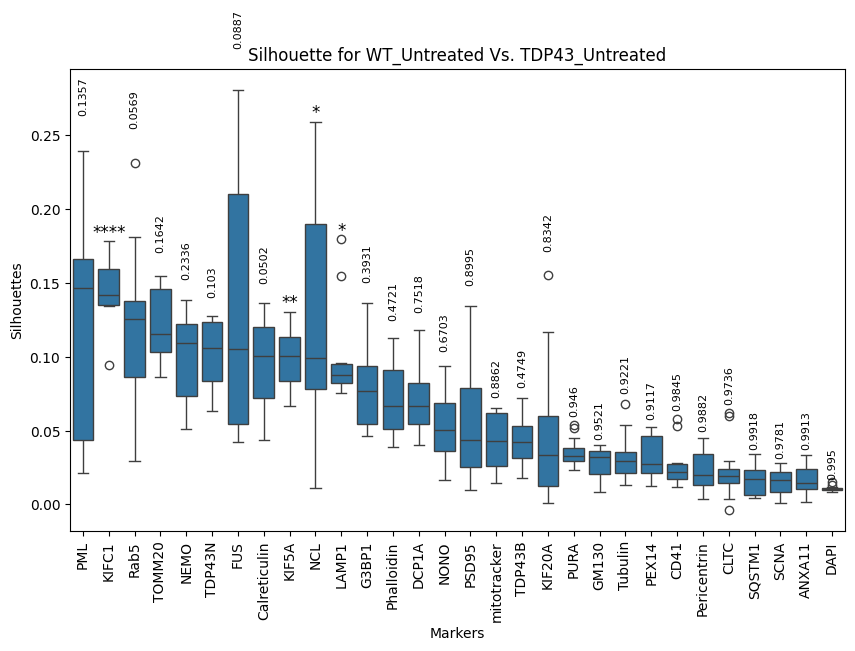

In [8]:
import seaborn as sns

conditions = df_merged['condition'].unique()
for cond in conditions:
    # Sort the DataFrame by 'score'
    df_merged_cond = df_merged[df_merged['condition'] == cond]
    df_cond = df_merged_cond
    # df_cond = df_merged_cond.sort_values(by='silhouette', ascending=False)
    # Calculate median scores for each name
    median_silhouette = df_cond.groupby('marker')['silhouette'].median()

    # Sort the names by their median scores
    sorted_markers = median_silhouette.sort_values(ascending=False).index

    # Reorder df_merged based on the sorted names
    df_cond['marker'] = pd.Categorical(df_cond['marker'], categories=sorted_markers, ordered=True)
    df_cond = df_cond.sort_values('marker')
    
    # Create the box plot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='marker', y='silhouette', data=df_cond)

    # Add asterisks based on p-value significance
    markers = df_cond['marker'].unique()

    for marker in markers:
        pval = df_cond[df_cond['marker'] == marker]['pvalues'].iloc[0]

        if pval <= 0.05:
            if pval <= 0.0001:
                asterisks = '****'
            elif pval <= 0.001:
                asterisks = '***'
            elif pval <= 0.01:
                asterisks = '**'
            else:
                asterisks = '*'

            # Get the median score for placing the asterisks above the boxplot
            # median_score = df_cond[df_cond['marker'] == marker]['silhouette'].median()
            max_score = df_cond[df_cond['marker'] == marker]['silhouette'].max()

            # Add the asterisks above the box
            plt.text(markers.tolist().index(marker), max_score, asterisks, 
                     ha='center', va='bottom', fontsize=12)
        else:
            max_score = df_cond[df_cond['marker'] == marker]['silhouette'].max()
            plt.text(markers.tolist().index(marker), max_score + 0.1*max_score, round(pval,4), 
                     ha='center', va='bottom', fontsize=8, rotation=90)

    # Labeling the axes
    plt.xticks(rotation=90)
    plt.xlabel('Markers')
    plt.ylabel('Silhouettes')
    plt.title(f'Silhouette for {cond} Vs. {baseline}')

    # Show the plot
    plt.show()

#### heatmap

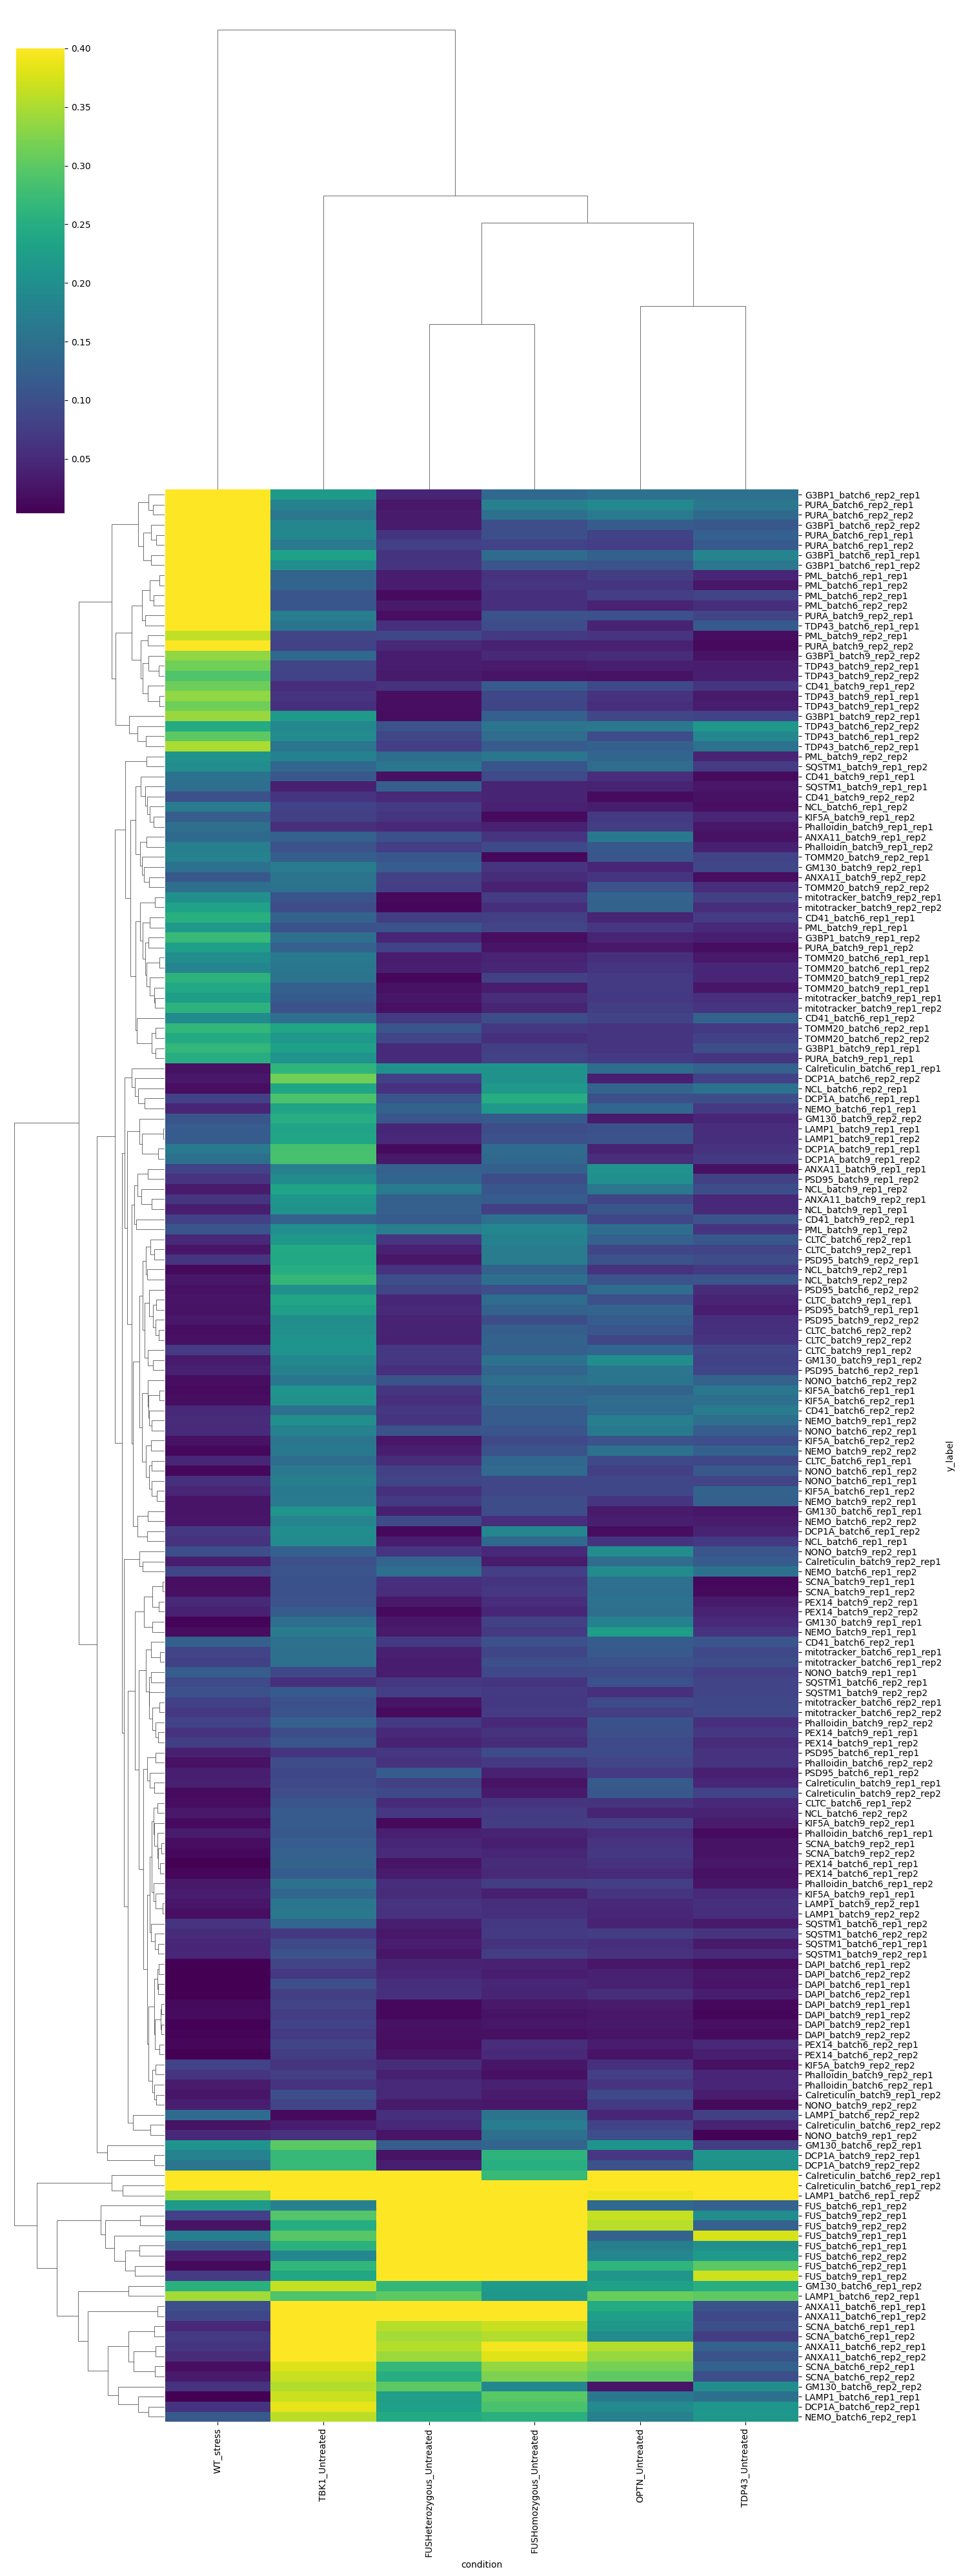

In [146]:
df_merged_copy = df_merged.copy()
df_merged_copy = df_merged_copy[df_merged_copy['condition'] != 'FUSRevertant_Untreated']

# Create a new column for the concatenated y-axis labels
df_merged_copy['y_label'] = df_merged_copy['marker'] + '_' + df_merged_copy['batch'] + '_' + df_merged_copy['repA'] + '_' + df_merged_copy['repB']

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_pivot = df_merged_copy.pivot(index='y_label', columns='condition', values='silhouette')
# df_pivot.fillna(0, inplace=True)

# Generate the clustermap
sns.clustermap(df_pivot, cmap='viridis', figsize=(15, 40), row_cluster=True, col_cluster=True,  yticklabels=True, vmax=0.4)

# Show the plot
plt.show()


#### heatmap - correlation

/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


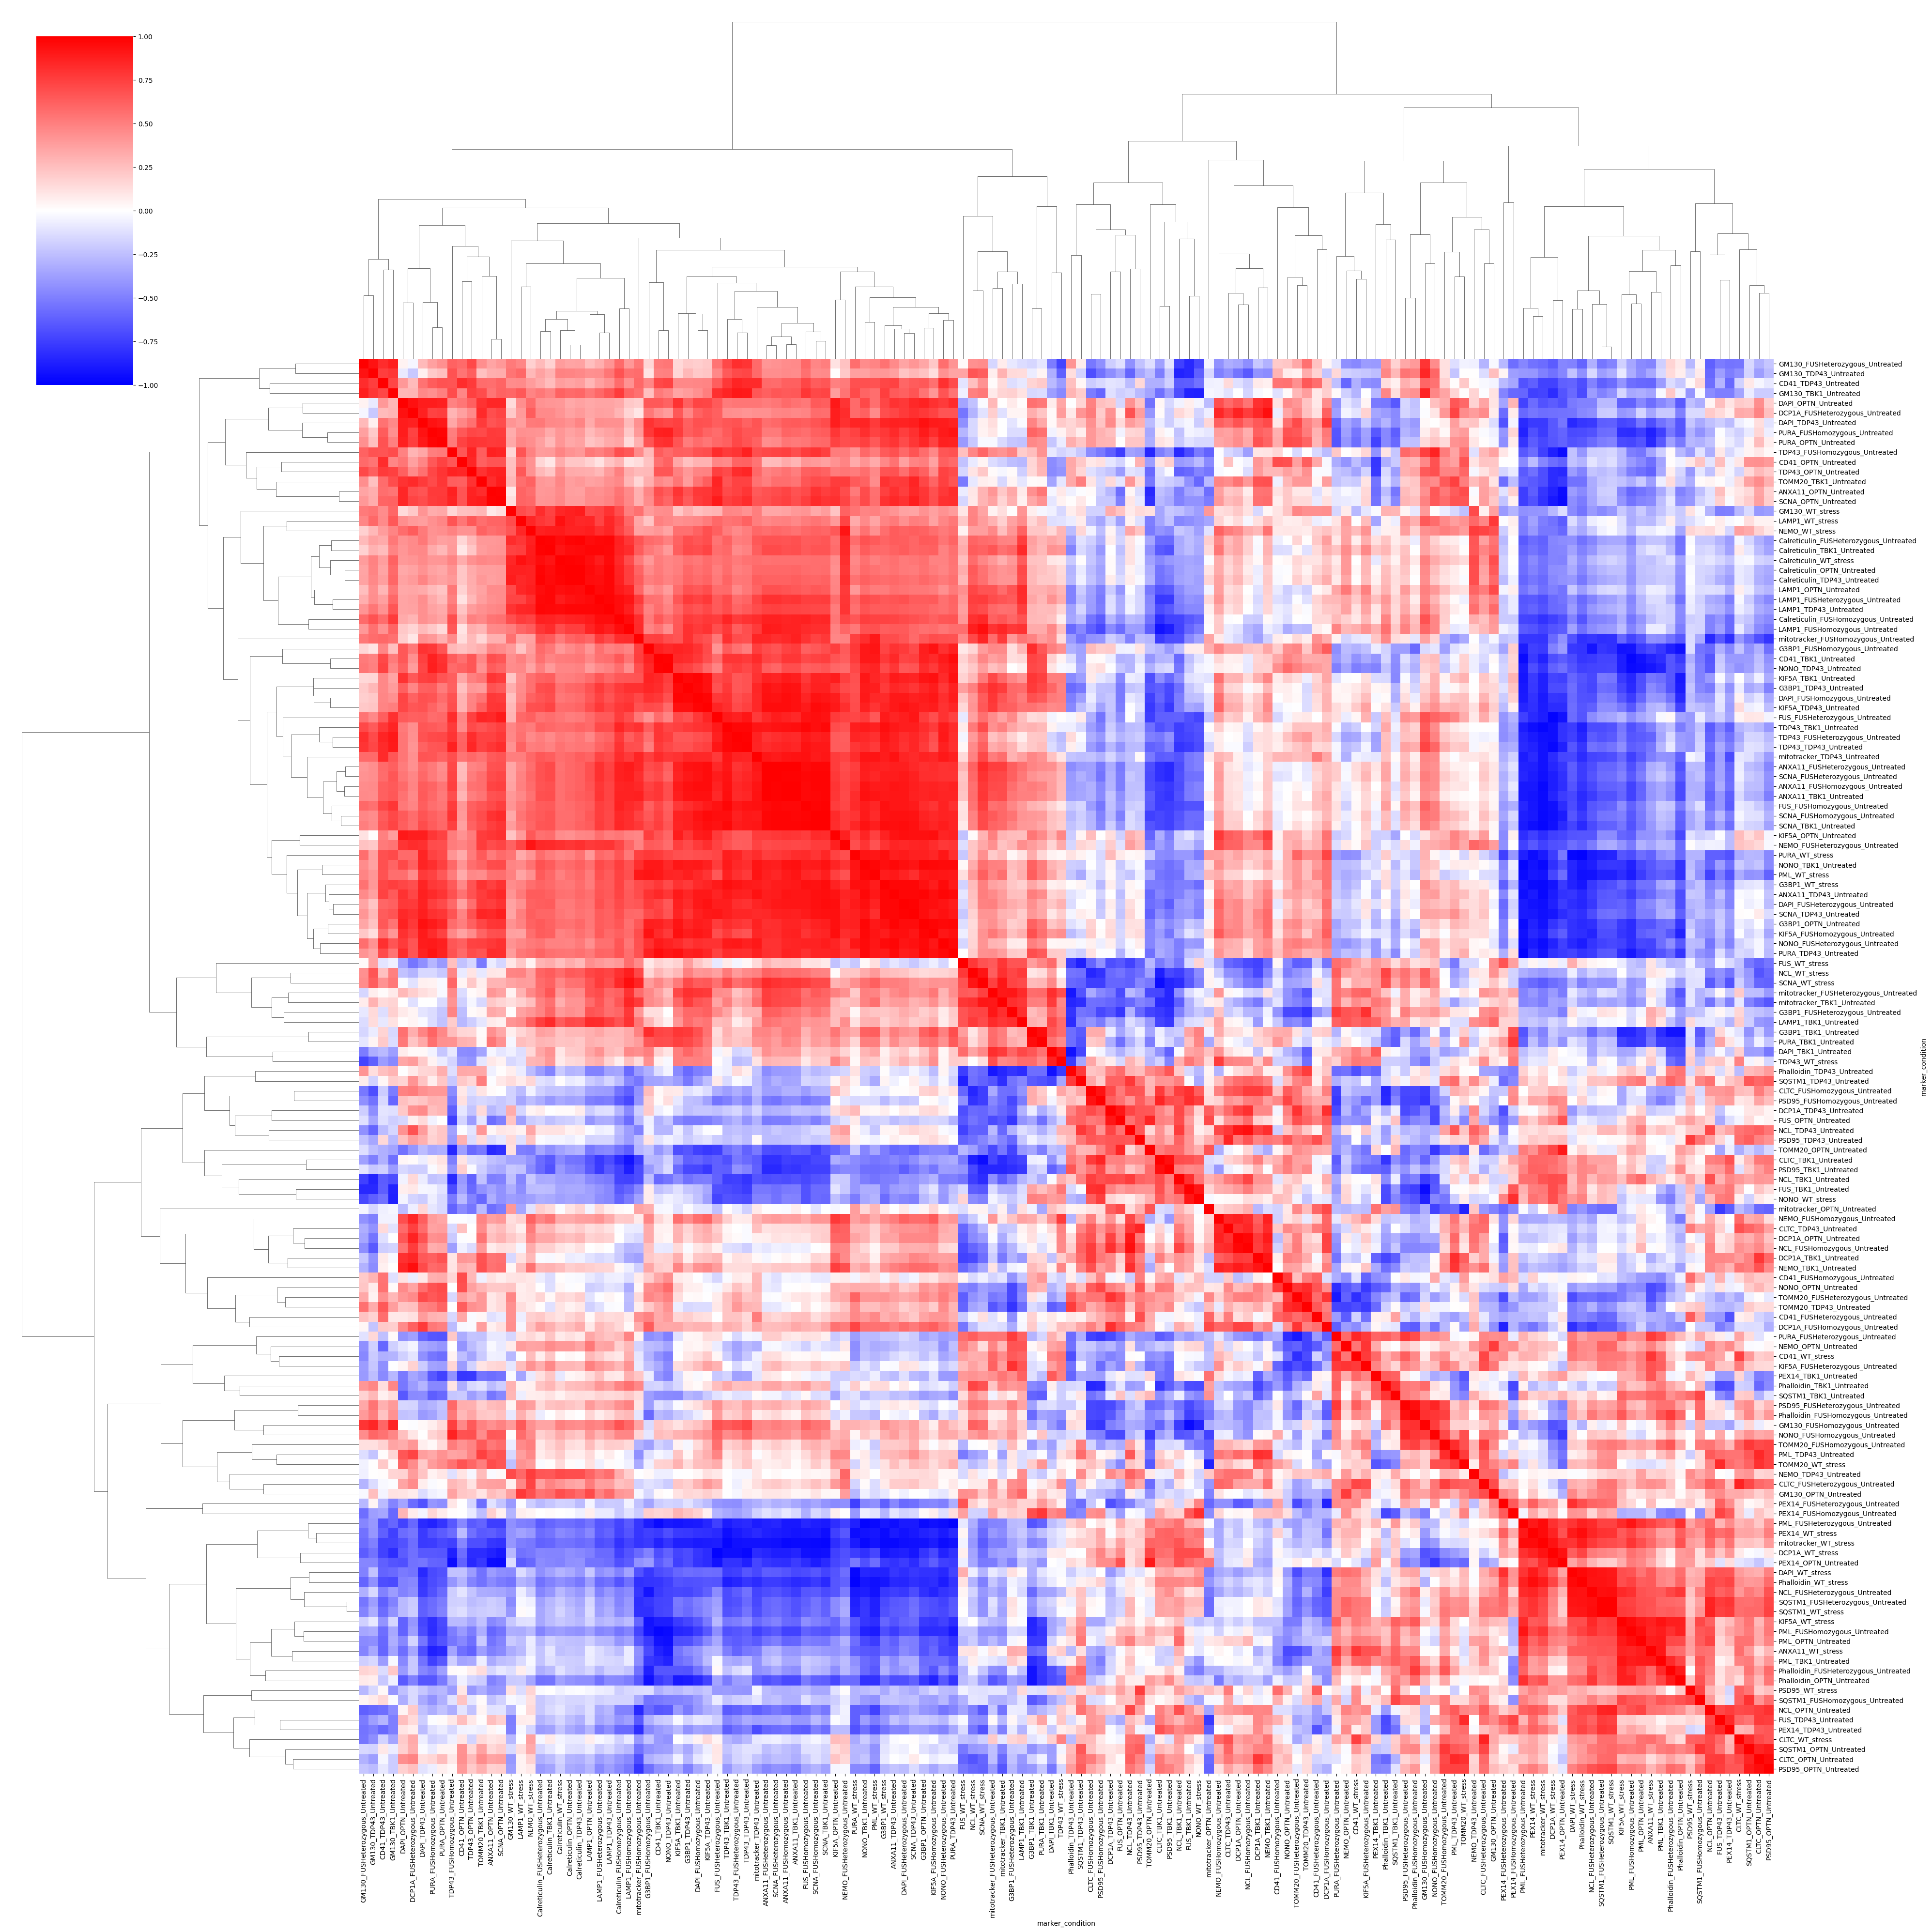

In [162]:
df_merged_corr_copy = df_merged.copy()
df_merged_corr_copy = df_merged_corr_copy[df_merged_corr_copy['condition'] != 'FUSRevertant_Untreated']


df_merged_corr_copy['marker_condition'] = df_merged_corr_copy['marker'] + '_' + df_merged_corr_copy['condition']
df_merged_corr_copy['batch_repA_repB'] = df_merged_corr_copy['batch'] + '_' + df_merged_corr_copy['repA'] + '_' + df_merged_corr_copy['repB']

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_merged_corr_copy_pivot = df_merged_corr_copy.pivot(index='batch_repA_repB', columns='marker_condition', values='silhouette')
df_corr = df_merged_corr_copy_pivot.corr()

# Generate the clustermap
sns.clustermap(df_corr, cmap='bwr', figsize=(40, 40), row_cluster=True, col_cluster=True,  yticklabels=True, xticklabels=True,
               vmin=-1, vmax=1)

# # # Show the plot
plt.show()


#### <font color='red'> heatmap - pvalues</font> - <font color='yellow'>The chosen one!</font>

##### least_changed

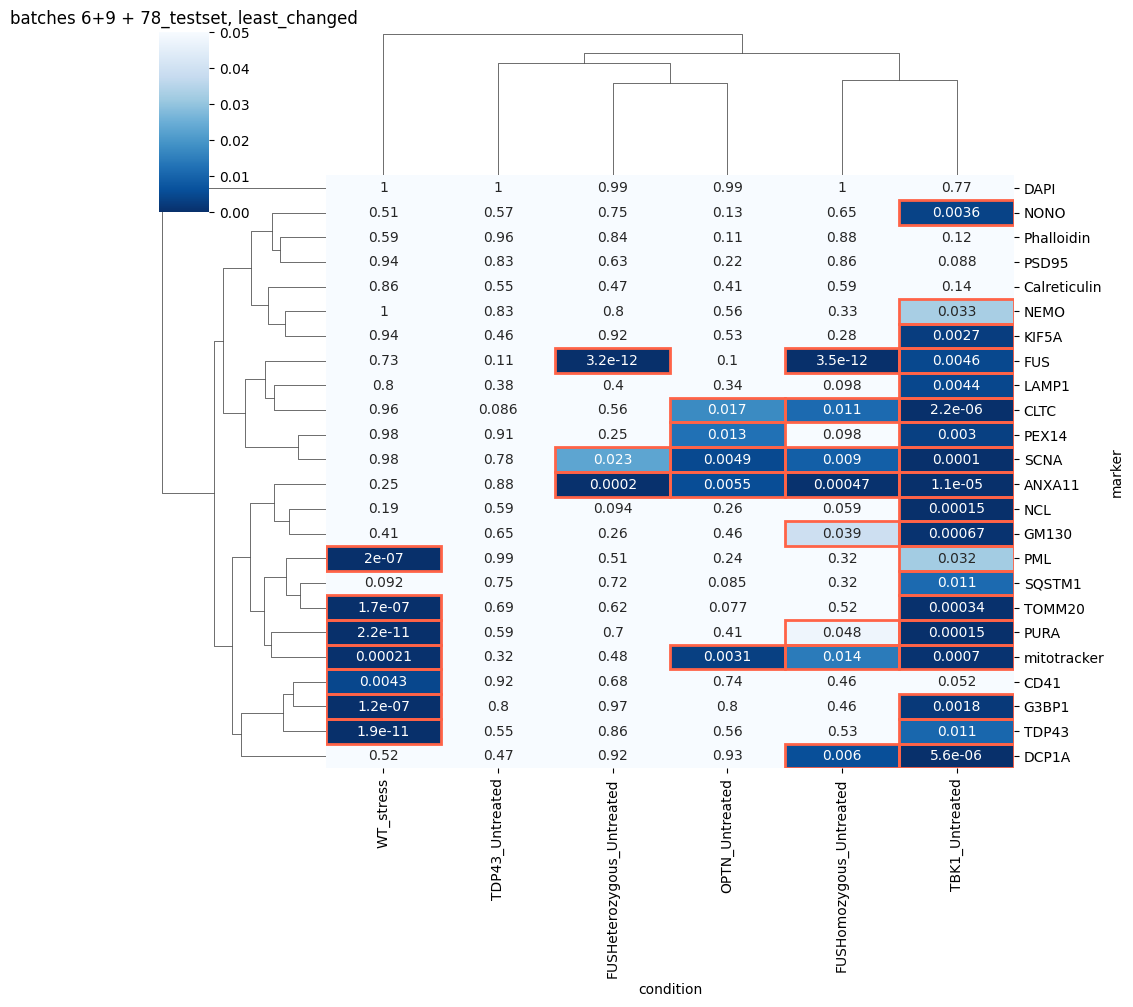

In [19]:
# b69 + 78test (least changed)

df_merged_pvalues_copy = df_merged.copy()
df_merged_pvalues_copy = df_merged_pvalues_copy[df_merged_pvalues_copy['condition'] != 'FUSRevertant_Untreated']

df_merged_pvalues_copy = df_merged_pvalues_copy[["marker", "condition", "pvalues"]].drop_duplicates().reset_index(drop=True)

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_pivot_pvalues = df_merged_pvalues_copy.pivot(index='marker', columns='condition', values='pvalues')

linkage_row = scipy.cluster.hierarchy.linkage(df_pivot_pvalues,
                                          method='average', # 'complete', 'average', 'median', 'ward'
                                          metric='euclidean',
                                          optimal_ordering=True)
linkage_col = scipy.cluster.hierarchy.linkage(df_pivot_pvalues.T,
                                          method='average', # 'complete', 'average', 'median', 'ward'
                                          metric='euclidean',
                                          optimal_ordering=True)

# Generate the clustermap
g = sns.clustermap(df_pivot_pvalues, cmap='Blues_r', figsize=(10, 10), row_cluster=True, col_cluster=True,
                   row_linkage=linkage_row, col_linkage=linkage_col,
               yticklabels=True, xticklabels=True, annot=True, vmax=0.05)


row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the DataFrame based on the clustering
clustered_df = df_pivot_pvalues.iloc[row_order, col_order]

for i in range(clustered_df.shape[0]):
    for j in range(clustered_df.shape[1]):
        if clustered_df.iloc[i, j] <= 0.05:
            # Add a rectangle around the cell
            g.ax_heatmap.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='tomato', lw=2))

# # Show the plot

plt.title("batches 6+9 + 78_testset, least_changed")
plt.show()


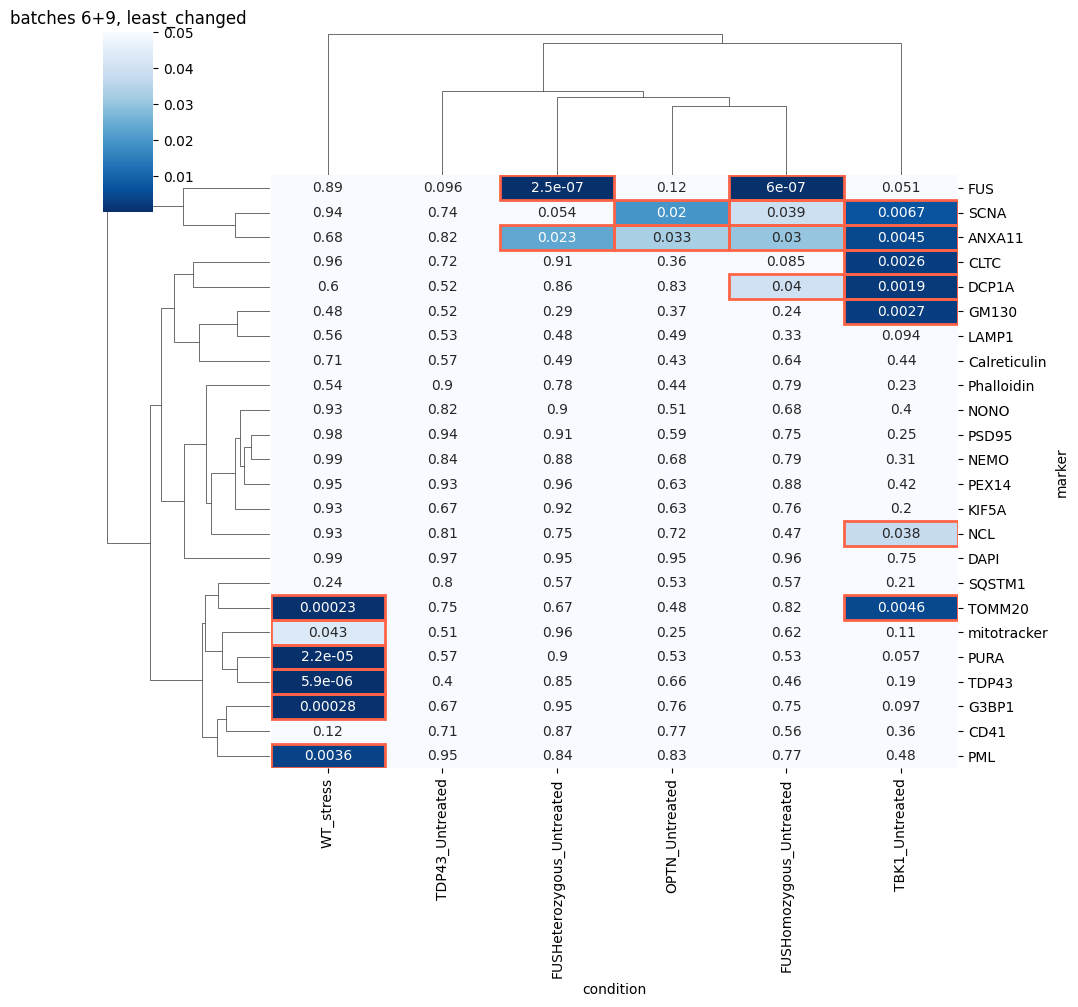

In [22]:
# only 6 + 9 (least changed)

from matplotlib.patches import Rectangle

df_merged_pvalues_copy = df_merged.copy()
df_merged_pvalues_copy = df_merged_pvalues_copy[df_merged_pvalues_copy['condition'] != 'FUSRevertant_Untreated']

df_merged_pvalues_copy = df_merged_pvalues_copy[["marker", "condition", "pvalues"]].drop_duplicates().reset_index(drop=True)

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_pivot_pvalues = df_merged_pvalues_copy.pivot(index='marker', columns='condition', values='pvalues')

linkage_row = scipy.cluster.hierarchy.linkage(df_pivot_pvalues,
                                          method='average', # 'complete', 'average', 'median', 'ward'
                                          metric='euclidean',
                                          optimal_ordering=True)
linkage_col = scipy.cluster.hierarchy.linkage(df_pivot_pvalues.T,
                                          method='average', # 'complete', 'average', 'median', 'ward'
                                          metric='euclidean',
                                          optimal_ordering=True)

# Generate the clustermap
g = sns.clustermap(df_pivot_pvalues, cmap='Blues_r', figsize=(10, 10), row_cluster=True, col_cluster=True,
                   row_linkage=linkage_row, col_linkage=linkage_col,
               yticklabels=True, xticklabels=True, annot=True, vmax=0.05)


row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the DataFrame based on the clustering
clustered_df = df_pivot_pvalues.iloc[row_order, col_order]

for i in range(clustered_df.shape[0]):
    for j in range(clustered_df.shape[1]):
        if clustered_df.iloc[i, j] <= 0.05:
            # Add a rectangle around the cell
            g.ax_heatmap.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='tomato', lw=2))


# # Show the plot
plt.title("batches 6+9, least_changed")
plt.show()


##### opencell new 

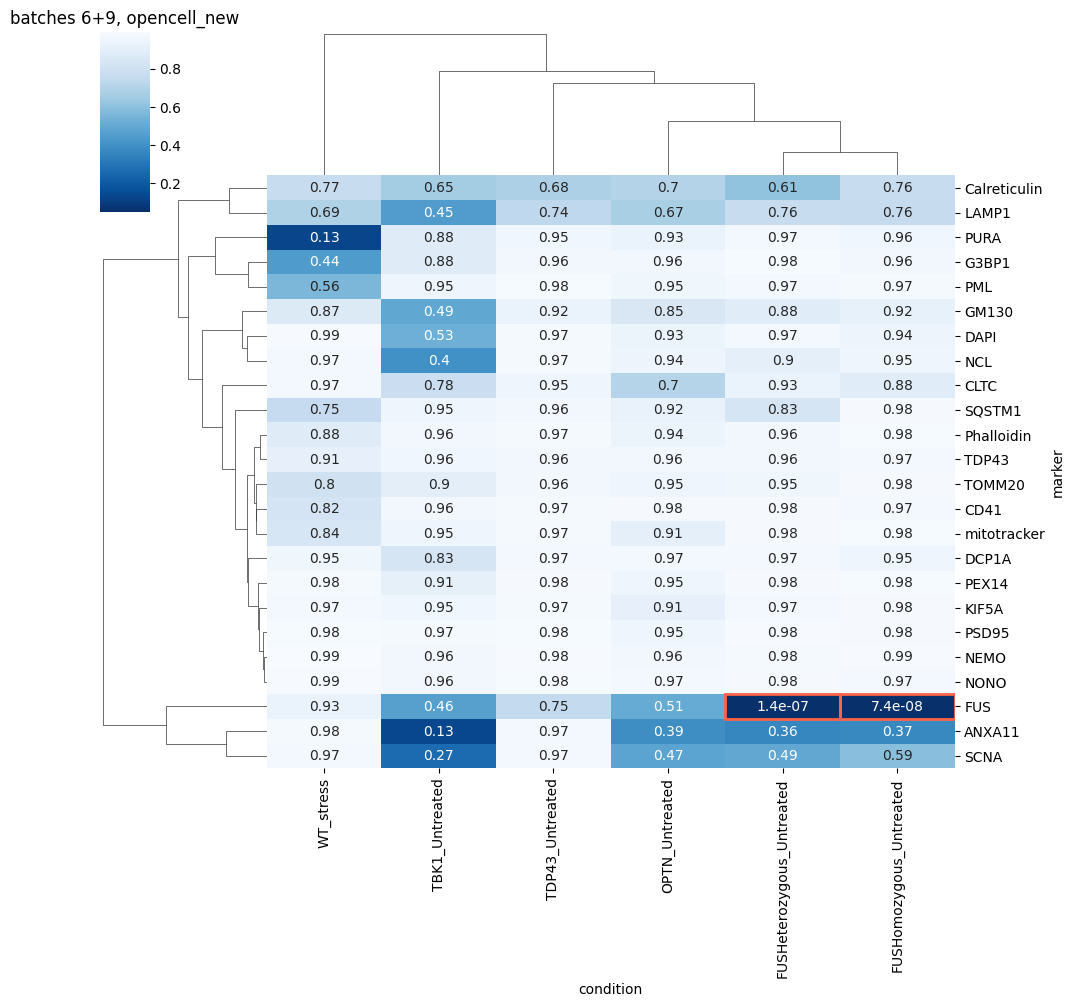

In [239]:
# only 6 + 9 (opencell new)

from matplotlib.patches import Rectangle

df_merged_pvalues_copy = df_merged.copy()
df_merged_pvalues_copy = df_merged_pvalues_copy[df_merged_pvalues_copy['condition'] != 'FUSRevertant_Untreated']

df_merged_pvalues_copy = df_merged_pvalues_copy[["marker", "condition", "pvalues"]].drop_duplicates().reset_index(drop=True)

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_pivot_pvalues = df_merged_pvalues_copy.pivot(index='marker', columns='condition', values='pvalues')

# Generate the clustermap
g = sns.clustermap(df_pivot_pvalues, cmap='Blues_r', figsize=(10, 10), row_cluster=True, col_cluster=True,
               yticklabels=True, xticklabels=True, annot=True, vmin=0.05)


row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the DataFrame based on the clustering
clustered_df = df_pivot_pvalues.iloc[row_order, col_order]

for i in range(clustered_df.shape[0]):
    for j in range(clustered_df.shape[1]):
        if clustered_df.iloc[i, j] <= 0.05:
            # Add a rectangle around the cell
            g.ax_heatmap.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='tomato', lw=2))

# # Show the plot
plt.title("batches 6+9, opencell_new")
plt.show()


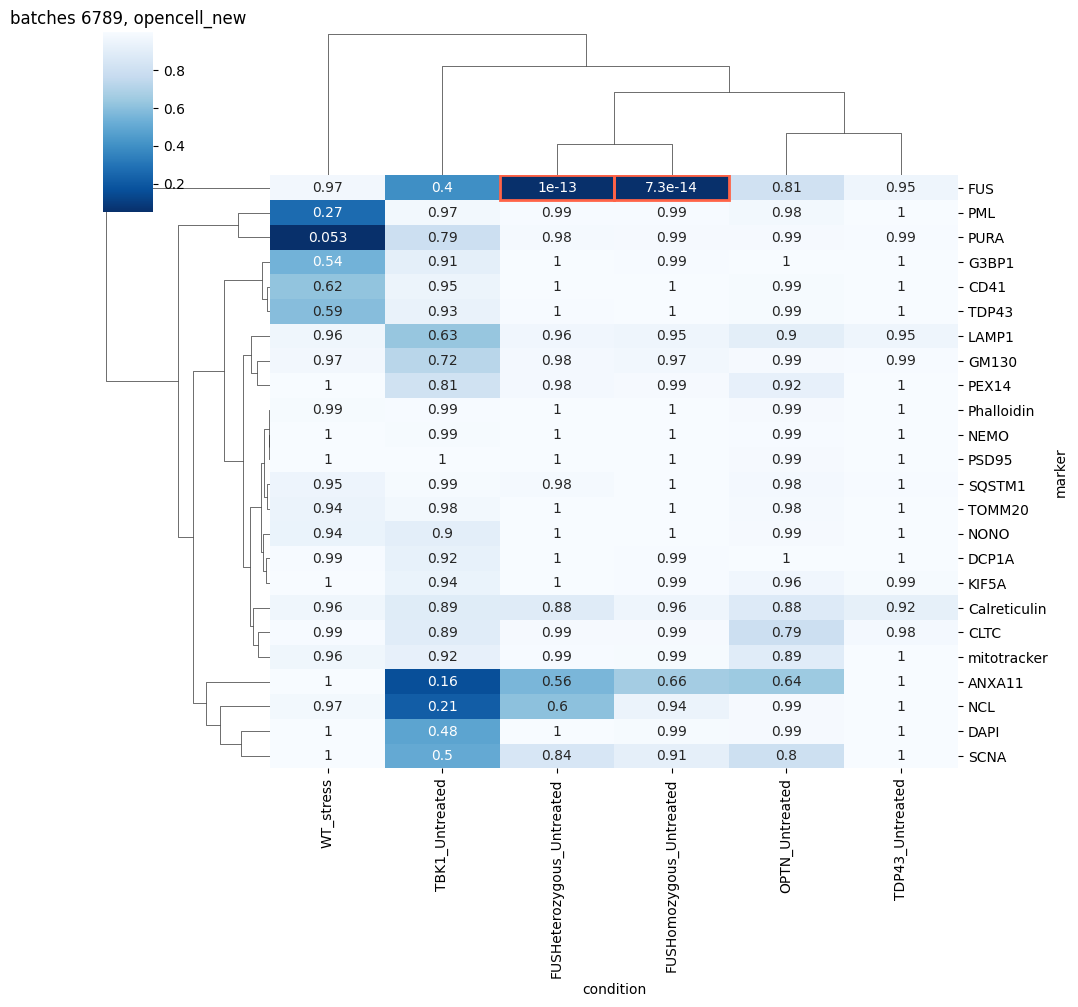

In [254]:
# 6 + 9 + full 7+8 (opencell new)

from matplotlib.patches import Rectangle

df_merged_pvalues_copy = df_merged.copy()
df_merged_pvalues_copy = df_merged_pvalues_copy[df_merged_pvalues_copy['condition'] != 'FUSRevertant_Untreated']

df_merged_pvalues_copy = df_merged_pvalues_copy[["marker", "condition", "pvalues"]].drop_duplicates().reset_index(drop=True)

# Pivot the DataFrame to get conditions on the x-axis and y_label on the y-axis
df_pivot_pvalues = df_merged_pvalues_copy.pivot(index='marker', columns='condition', values='pvalues')

# Generate the clustermap
g = sns.clustermap(df_pivot_pvalues, cmap='Blues_r', figsize=(10, 10), row_cluster=True, col_cluster=True,
               yticklabels=True, xticklabels=True, annot=True, vmin=0.05)


row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the DataFrame based on the clustering
clustered_df = df_pivot_pvalues.iloc[row_order, col_order]

for i in range(clustered_df.shape[0]):
    for j in range(clustered_df.shape[1]):
        if clustered_df.iloc[i, j] <= 0.05:
            # Add a rectangle around the cell
            g.ax_heatmap.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='tomato', lw=2))

# # Show the plot
plt.title("batches 6789, opencell_new")
plt.show()


### old

In [51]:
cond = 'TBK1_Untreated'
def get_p(func):
    return lambda x: func(x.loc[x['condition'] == cond, 'silhouette'], x.loc[x['condition'] == 'WT_Untreated', 'silhouette'], alternative='greater')[1]

print(scores.groupby('marker').apply(get_p(ttest_ind)).sort_values(ascending=True))
print(scores.groupby('marker').apply(get_p(ranksums)).sort_values(ascending=True))
print(scores.groupby('marker').apply(get_p(mannwhitneyu)).sort_values(ascending=True))

marker
DCP1A           0.001804
CLTC            0.002423
GM130           0.002647
ANXA11          0.004495
TOMM20          0.004603
SCNA            0.006817
NCL             0.046317
FUS             0.048536
PURA            0.049941
LAMP1           0.101867
G3BP1           0.105127
mitotracker     0.108905
KIF5A           0.166024
TDP43           0.203532
Phalloidin      0.238263
SQSTM1          0.250846
PSD95           0.257314
NEMO            0.306205
CD41            0.345537
NONO            0.398599
Calreticulin    0.427899
PEX14           0.442569
PML             0.462429
dtype: float64
marker
DCP1A           0.002287
CLTC            0.004326
GM130           0.005859
TOMM20          0.005859
ANXA11          0.023000
SCNA            0.046446
NCL             0.086084
PURA            0.086084
G3BP1           0.103789
LAMP1           0.103789
KIF5A           0.123998
FUS             0.146811
TDP43           0.172281
PSD95           0.337212
mitotracker     0.337212
NONO            0.376

/tmp/ipykernel_2240266/810732817.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(scores.groupby('marker').apply(get_p(ttest_ind)).sort_values(ascending=True))
/tmp/ipykernel_2240266/810732817.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(scores.groupby('marker').apply(get_p(ranksums)).sort_values(ascending=True))
/tmp/ipykernel_2240266/810732817.py:7: DeprecationWarning: DataFrameGroup

In [49]:
cond = 'FUSHomozygous_Untreated'
def get_p(func):
    return lambda x: func(x.loc[x['condition'] == cond, 'silhouette'], x.loc[x['condition'] == 'WT_Untreated', 'silhouette'], alternative='greater')[1]

print(scores.groupby('marker').apply(get_p(ttest_ind)).sort_values(ascending=True))
print(scores.groupby('marker').apply(get_p(ranksums)).sort_values(ascending=True))
print(scores.groupby('marker').apply(get_p(mannwhitneyu)).sort_values(ascending=True))

marker
FUS             6.688711e-07
ANXA11          3.010773e-02
DCP1A           3.438090e-02
SCNA            3.690206e-02
CLTC            8.987786e-02
GM130           2.230556e-01
LAMP1           3.385489e-01
TDP43           4.572790e-01
NCL             4.920274e-01
PURA            5.487384e-01
CD41            5.552825e-01
SQSTM1          5.718807e-01
mitotracker     6.043287e-01
Calreticulin    6.269821e-01
NONO            6.980136e-01
KIF5A           7.311893e-01
PSD95           7.509925e-01
PML             7.517365e-01
G3BP1           7.592238e-01
Phalloidin      7.958622e-01
NEMO            7.974276e-01
TOMM20          8.164568e-01
PEX14           8.831320e-01
dtype: float64
marker
FUS             0.000389
ANXA11          0.046446
SCNA            0.046446
DCP1A           0.057592
CLTC            0.200407
GM130           0.231125
LAMP1           0.376357
NCL             0.416817
TDP43           0.458180
PURA            0.458180
PML             0.500000
PEX14           0.500000
mito

/tmp/ipykernel_2240266/1546847570.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(scores.groupby('marker').apply(get_p(ttest_ind)).sort_values(ascending=True))
/tmp/ipykernel_2240266/1546847570.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(scores.groupby('marker').apply(get_p(ranksums)).sort_values(ascending=True))
/tmp/ipykernel_2240266/1546847570.py:7: DeprecationWarning: DataFrameGr

In [38]:
scores

,silhouette,dunn,marker,condition,repA,repB,batch
0,0.494558,0.821908,ANXA11,FUSHomozygous_Untreated,rep1,rep1,batch6
0,0.485534,0.839869,ANXA11,FUSHomozygous_Untreated,rep1,rep2,batch6
0,0.393730,1.060711,ANXA11,FUSHomozygous_Untreated,rep2,rep1,batch6
0,0.381054,1.088912,ANXA11,FUSHomozygous_Untreated,rep2,rep2,batch6
0,0.077936,3.145362,CD41,FUSHomozygous_Untreated,rep1,rep1,batch6
...,...,...,...,...,...,...,...
0,0.018601,NaN,TOMM20,WT_Untreated,rep1_part2,rep2_part2,batch9
0,-0.000829,NaN,mitotracker,WT_Untreated,rep1_part1,rep2_part1,batch9
0,0.176316,NaN,mitotracker,WT_Untreated,rep1_part1,rep2_part2,batch9
0,0.158294,NaN,mitotracker,WT_Untreated,rep1_part2,rep2_part1,batch9


In [34]:
from statsmodels.formula.api import mixedlm

markers = scores['marker'].unique()
p_values = {}
for marker in markers:
    score_marker = scores[scores['marker'] == marker].reset_index(drop=True)
    model = mixedlm("silhouette~condition", groups="batch", data=score_marker)
    result = model.fit()
    p_value = result.pvalues["condition[T.WT_Untreated]"]
    p_values[marker] = {"p_value": p_value}

p_values = pd.DataFrame.from_dict(p_values, orient='index')
p_values = p_values['p_value'].sort_values(ascending=True)
p_values

/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/labs/hornsteinlab/sagyk/anaconda3/envs/momapsD/lib/

FUS             5.388266e-16
ANXA11          1.151916e-02
SCNA            1.561441e-02
DCP1A           5.844431e-02
DAPI            6.846028e-02
CLTC            1.468147e-01
PEX14           2.174915e-01
TOMM20          3.436124e-01
NEMO            4.101749e-01
Phalloidin      4.148826e-01
GM130           4.299829e-01
KIF5A           4.308084e-01
PML             4.550628e-01
G3BP1           4.785713e-01
PSD95           4.801255e-01
LAMP1           5.934083e-01
NONO            6.326834e-01
Calreticulin    6.686203e-01
mitotracker     7.596270e-01
SQSTM1          8.643996e-01
CD41            8.745285e-01
TDP43           9.170315e-01
PURA            9.360653e-01
NCL             9.364135e-01
Name: p_value, dtype: float64